In [74]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from pydub import AudioSegment

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix

## CDPD

In [125]:
df = pd.read_csv('../data/CDPD/training_data.csv') 
len(df)

942

Отделение данных, вообще нам нужны только данные, которые обязательно имеют в себе Аортальный и Митральный клапаны, или хотя бы один из них, поэтому мы только такие и берем, но посмотреть как может обучиться со всеми данными тоже интересно, поэтому таблицы метрик в конце файла есть и для всех данных и для отобранных

In [3]:
df = df[df['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])&(df['Murmur']!='Unknown')]
len(df)

595

In [4]:
df['Locations'].unique()

array(['AV+PV+TV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+PV+MV', 'AV+MV+MV',
       'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV',
       'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV',
       'AV+AV+PV+TV+MV+MV'], dtype=object)

In [5]:
df['Murmur locations'].unique()

array([nan, 'AV+MV+PV+TV', 'TV', 'MV+TV', 'MV+PV+TV', 'AV+PV+TV',
       'AV+MV+PV', 'MV+PV', 'AV+MV+PV+Phc+TV', 'MV', 'AV+PV', 'PV',
       'AV+TV', 'PV+TV', 'AV+MV', 'AV'], dtype=object)

In [6]:
# Определение порядка объединения файлов
order = ['MV', 'AV', 'PV', 'Ph', 'TV']
directory = '../data/CDPD/training_data/'

def combine_audio(filename):
    # Получение списка файлов для текущей строки
    files_to_combine = []
    for location in order:
        file_name = f"{directory}{filename}_{location}.wav"
        if os.path.exists(file_name):
            files_to_combine.append(file_name)
    
    # Объединение файлов
    combined_audio = AudioSegment.empty()
    for file in files_to_combine:
        audio = AudioSegment.from_wav(file)
        combined_audio += audio
    
    # Сохранение объединенного аудио
    output_file_name = f"{directory}{filename}_combined.wav"
    combined_audio.export(output_file_name, format="wav")
    return output_file_name

def load_audio_data(file_names):
    X = []
    for i, file_name in enumerate(tqdm(file_names)):
        # Объединение аудиофайлов
        combined_file_name = combine_audio(file_name)
        try:
            # Загрузка объединенного аудиофайла и извлечение признаков
            audio, sr = librosa.load(combined_file_name)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr)
            mfcc_mean = np.mean(mfcc, axis=1)
            
            # Удаление временного объединенного файла
            os.remove(combined_file_name)
            
            X.append(mfcc_mean)
        except:
            print(combined_file_name, i)
            continue
    
    return np.array(X)

## ACD 

In [7]:
patients = "../data/Пациенты.csv"
norm_dir = "../data/норма"
patology_dir = "../data/патология"

In [8]:
def find_wav_files(directory):
    X = []
    dir_path = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                audio, sr = librosa.load(os.path.join(root, file))
                mfcc = librosa.feature.mfcc(y=audio, sr=sr)
                mfcc_mean = np.mean(mfcc, axis=1)
                
                X.append(mfcc_mean)
                dir_path.append(root)
    
    return X, dir_path

## prepare data

In [11]:
# Norm - 0, MK patology - 1, AK patology - 2, Other patology - 3

In [90]:
# загрузка датасета для мультилейбл
cda, cda_paths = find_wav_files(norm_dir)
norm = [[1, 0, 0, 0]] * len(cda_paths)
patology_files, patology_paths = find_wav_files(patology_dir)
cda.extend(patology_files)
patology = []
for i in patology_paths:
    pat_label = [0, 0, 0, 0]
    if 'МК' in i:
        pat_label[1] = 1
    if "АК" in i:
        pat_label[2] = 1
    if "ТК" in i or "ЛА" in i:
        pat_label[3] = 1
    patology.append(pat_label)

cda = np.array(cda)
cda_labels = norm + patology

In [91]:
print(len(cda), len(cda_labels))

51 51


In [14]:
# я настроила правильную разметку в мультилейбл в сда, теперь надо также сделать для cdpd, потом просто бахнуть кучу обучений

In [15]:
# к счастью нет строк где указано что есть патололгия но не указана какая
print(df[(df['Murmur']=='Present')&(df['Murmur locations'].isna())])

# и ровно там где нет патологии не просочилась лишняя инфа о локациях, все чисто, а значит мы можем стаить метки на основе одной колонки
print(len(df[df['Murmur']=='Absent']), 
len(df[df['Murmur locations'].isna()]),
len(df[(df['Murmur']=='Absent')&(df['Murmur locations'].isna())]))


Empty DataFrame
Columns: [Patient ID, Locations, Age, Sex, Height, Weight, Pregnancy status, Murmur, Murmur locations, Most audible location, Systolic murmur timing, Systolic murmur shape, Systolic murmur grading, Systolic murmur pitch, Systolic murmur quality, Diastolic murmur timing, Diastolic murmur shape, Diastolic murmur grading, Diastolic murmur pitch, Diastolic murmur quality, Campaign, Additional ID]
Index: []

[0 rows x 22 columns]
474 474 474


In [16]:
df['Murmur locations'].unique()

array([nan, 'AV+MV+PV+TV', 'TV', 'MV+TV', 'MV+PV+TV', 'AV+PV+TV',
       'AV+MV+PV', 'MV+PV', 'AV+MV+PV+Phc+TV', 'MV', 'AV+PV', 'PV',
       'AV+TV', 'PV+TV', 'AV+MV', 'AV'], dtype=object)

In [126]:
file_names_cdpd = list(df['Patient ID']) 
locations = list(df['Murmur locations'])

# Absent = Normal = 0, Present - see loc, then 1-3 
cdpd_data = load_audio_data(file_names_cdpd)

 28%|██▊       | 266/942 [02:13<06:43,  1.67it/s]

../data/CDPD/training_data/50321_combined.wav 266


100%|██████████| 942/942 [07:09<00:00,  2.20it/s]


In [95]:
locations


[nan,
 'AV+MV+PV+TV',
 'TV',
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 'MV+TV',
 'MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 'AV+MV+PV+TV',
 'MV+TV',
 'AV+MV+PV+TV',
 'MV+PV+TV',
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 'AV+MV+PV+TV',
 'MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 'AV+PV+TV',
 'MV+PV+TV',
 'AV+MV+PV+TV',
 'AV+MV+PV+TV',
 'AV+MV+PV',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'MV+PV',
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'MV+TV',
 nan,
 'AV+MV+PV+TV',
 'AV+PV+TV',
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 'AV+MV+PV+TV',
 nan,
 nan,
 'AV+MV+PV+TV',
 'AV+MV+PV+TV',
 nan,
 nan,
 nan,
 nan,
 nan,
 'AV+PV+TV',
 'AV+MV+PV+TV',

In [128]:
cdpd_labels = []
for i in locations:
    pat_label = [0, 0, 0, 0]
    if type(i) != type('some_str'):
        pat_label[0] = 1
    else:
        if 'MV' in i:
            pat_label[1] = 1
        if "AV" in i:
            pat_label[2] = 1
        if "PV" in i or "Phc" in i or "TV" in i:
            pat_label[3] = 1
    cdpd_labels.append(pat_label)

In [129]:
del cdpd_labels[267] # [141] # [267]

In [130]:
cdpd_labels = np.array(cdpd_labels)

In [131]:
print(len(cdpd_data), len(cdpd_labels))

941 941


In [132]:
cdpd_labels

array([[1, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [133]:
cdpd_data.shape

(941, 20)

## data

In [134]:
# big_data, big_labels = cdpd_data, cdpd_labels

In [124]:
# little_data, little_labels = cdpd_data, cdpd_labels

In [143]:
cdpd_data, cdpd_labels = little_data, little_labels 

In [144]:
# CDPD data
X_train, X_test, y_train, y_test = train_test_split(cdpd_data, cdpd_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
joblib.dump(scaler, "./models/standard_scaler.pkl")

['./models/standard_scaler.pkl']

In [42]:
import matplotlib.pyplot as plt

In [104]:
def classes_balance(data):
    count_per_class = np.sum(data, axis=0)
    print("Количество примеров с каждым классом:")
    for i, count in enumerate(count_per_class, 1):
        print(f"Класс {i}: {count}")

    # Считаем количество классов в каждом примере (суммируем по строкам)
    class_counts_per_sample = np.sum(data, axis=1)

    # Примеры с ровно 2 классами
    count_exactly_two = np.sum(class_counts_per_sample == 2)
    print(f"\nКоличество примеров с ровно 2 классами: {count_exactly_two}")

    # Примеры с 2 и более классами
    count_two_or_more = np.sum(class_counts_per_sample >= 2)
    print(f"Количество примеров с 2 и более классами: {count_two_or_more}")

/var/folders/bd/zdhwq3v13q12sq0_ry8dk2d80000gn/T/ipykernel_11412/503647061.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=count_per_class, palette="viridis")


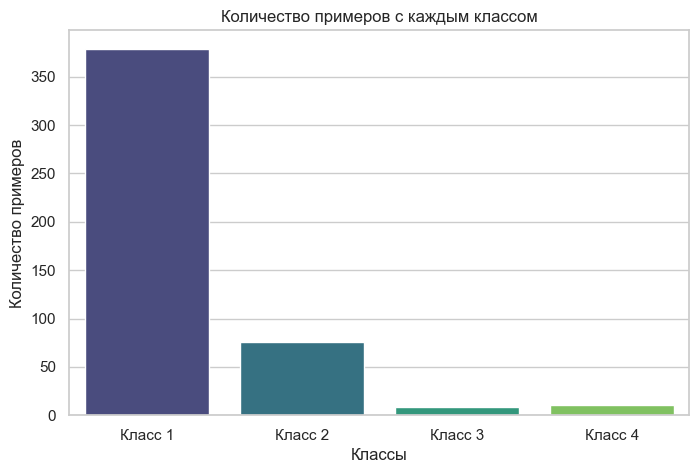

/var/folders/bd/zdhwq3v13q12sq0_ry8dk2d80000gn/T/ipykernel_11412/503647061.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Ровно 2 класса", "2 и более классов"],


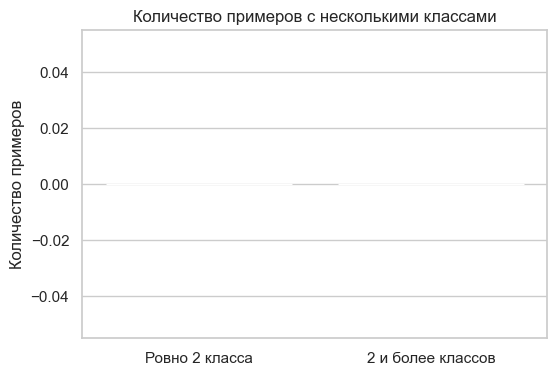

In [85]:
# count_per_class = np.sum(y_train, axis=0)
# class_labels = [f'Класс {i+1}' for i in range(y_train.shape[1])]

# # Подсчёт количества классов на примерах
# class_counts_per_sample = np.sum(y_train, axis=1)
# count_exactly_two = np.sum(class_counts_per_sample == 2)
# count_two_or_more = np.sum(class_counts_per_sample >= 2)

# # Настройка стиля
# sns.set_theme(style="whitegrid")

# # Рисуем столбчатую диаграмму по классам
# plt.figure(figsize=(8,5))
# sns.barplot(x=class_labels, y=count_per_class, palette="viridis")
# plt.title("Количество примеров с каждым классом")
# plt.ylabel("Количество примеров")
# plt.xlabel("Классы")
# plt.show()

# # Рисуем отдельный график для количества примеров с 2 и более классами
# plt.figure(figsize=(6,4))
# sns.barplot(x=["Ровно 2 класса", "2 и более классов"],
#             y=[count_exactly_two, count_two_or_more],
#             palette="magma")
# plt.title("Количество примеров с несколькими классами")
# plt.ylabel("Количество примеров")
# plt.show()

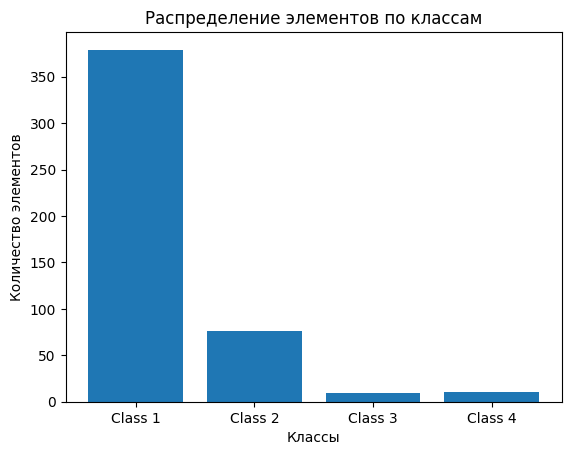

In [43]:
counts = y_train.sum(axis=0)

# Создаём подписи классов (если есть)
class_labels = [f'Class {i}' for i in range(1, y_train.shape[1] + 1)]

# Строим столбчатую диаграмму
plt.bar(class_labels, counts)
plt.xlabel('Классы')
plt.ylabel('Количество элементов')
plt.title('Распределение элементов по классам')
plt.show()

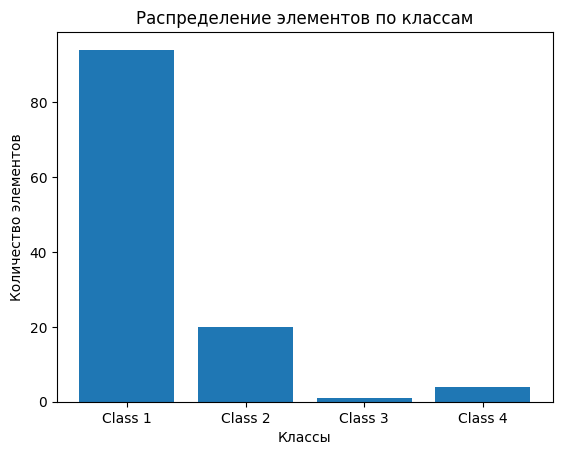

In [44]:
counts = y_test.sum(axis=0)

# Создаём подписи классов (если есть)
class_labels = [f'Class {i}' for i in range(1, y_test.shape[1] + 1)]

# Строим столбчатую диаграмму
plt.bar(class_labels, counts)
plt.xlabel('Классы')
plt.ylabel('Количество элементов')
plt.title('Распределение элементов по классам')
plt.show()

In [145]:
# Добавление cda в тестовую выборку

X_test_cdatest = np.vstack((X_test, cda))
y_test_cdatest = np.concatenate((y_test, cda_labels))

X_test_scaled_cdatest = scaler.transform(X_test_cdatest)

print("Новые размеры тестовых данных:")
print('for full cdpd test: ', X_train_scaled.shape, X_test_scaled.shape, )
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_cdatest shape: {X_test_cdatest.shape}")
print(f"y_test_cdatest shape: {y_test_cdatest.shape}")

Новые размеры тестовых данных:
for full cdpd test:  (475, 20) (119, 20)
X_test shape: (119, 20)
y_test shape: (119, 4)
X_test_cdatest shape: (170, 20)
y_test_cdatest shape: (170, 4)


In [146]:
# cdpd cda train test
X_train_cda, X_test_cda, y_train_cda, y_test_cda = train_test_split(cda, cda_labels, test_size=0.2, random_state=42)


X_train_cdpd_cda = np.vstack((X_train, X_train_cda))
y_train_cdpd_cda = np.concatenate((y_train, y_train_cda))
X_test_cdpd_cda = np.vstack((X_test, X_test_cda))
y_test_cdpd_cda = np.concatenate((y_test, y_test_cda))

scaler = StandardScaler()
X_train_scaled_cdpd_cda = scaler.fit_transform(X_train_cdpd_cda)
X_test_scaled_cdpd_cda = scaler.transform(X_test_cdpd_cda)

In [147]:
classes_balance(y_train_cdpd_cda)

Количество примеров с каждым классом:
Класс 1: 382
Класс 2: 112
Класс 3: 82
Класс 4: 124

Количество примеров с ровно 2 классами: 47
Количество примеров с 2 и более классами: 116


In [148]:
classes_balance(y_test_cdpd_cda)

Количество примеров с каждым классом:
Класс 1: 94
Класс 2: 31
Класс 3: 14
Класс 4: 31

Количество примеров с ровно 2 классами: 14
Количество примеров с 2 и более классами: 27


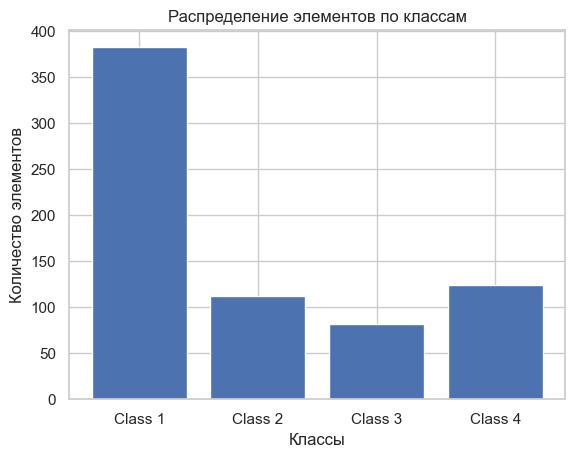

In [149]:
counts = y_train_cdpd_cda.sum(axis=0)

# Создаём подписи классов (если есть)
class_labels = [f'Class {i}' for i in range(1, y_test.shape[1] + 1)]

# Строим столбчатую диаграмму
plt.bar(class_labels, counts)
plt.xlabel('Классы')
plt.ylabel('Количество элементов')
plt.title('Распределение элементов по классам')
plt.show()

In [150]:
joblib.dump(scaler, "./models/multilabel_standard_scaler.pkl")

['./models/multilabel_standard_scaler.pkl']

## models

In [151]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

def show_matrix(mcm, class_names):
    n_classes = len(class_names)
    n_cols = 2
    n_rows = (n_classes + n_cols - 1) // n_cols  # округление вверх

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

    # Если axes двумерный, преобразуем в 1D для удобства итерации
    axes = axes.flatten() if n_classes > 1 else [axes]

    for i, (cm, label) in enumerate(zip(mcm, class_names)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'],
                    yticklabels=['True 0', 'True 1'],
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {label}')
        axes[i].set_xlabel('Predicted label')
        axes[i].set_ylabel('True label')

    # Скрываем пустые подграфики, если классов нечётное число
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [113]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true.ravel(), y_pred.ravel())
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)

def get_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average='weighted'),
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted'),
        "specificity": specificity_score(y_true, y_pred),
    },  multilabel_confusion_matrix(y_true, y_pred)

In [114]:
param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    "RandomForest": {"estimator__n_estimators": [100, 200]},
    "GradientBoosting": {"estimator__n_estimators": [100], "estimator__learning_rate": [0.1, 0.05]},
    "LogisticRegression": {"estimator__C": [1.0, 0.1]},
    "SVM": {"estimator__C": [1.0], "estimator__kernel": ['linear', 'rbf']},
}

base_models = {
    'LogisticRegression':  LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
}

In [115]:
def train(X_train_scaled, X_test_scaled, y_train, y_test, experiment=''):
    results = {}
    matrixes = {}
    for name, model in base_models.items():
        print(f"Training {name}...")
        grid = GridSearchCV(
            MultiOutputClassifier(model),
            param_grid=param_grids[name],
            scoring=make_scorer(f1_score, average='weighted'),
            cv=3
        )
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        results[name], matrixes[name] = get_metrics(y_test, y_pred)
        joblib.dump(best_model, f"./models/multilabel_{experiment}_{name}_best_model.pkl")
    return pd.DataFrame(results), matrixes



## full cdpd

In [118]:
results, matrixes_cdpd = train(X_train_scaled, X_test_scaled, y_train, y_test, experiment='cdpd')

Training LogisticRegression...
Training RandomForest...
Training GradientBoosting...
Training SVM...


In [119]:
# с отобранными по локациям данными правильными
results

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.798319,0.781513,0.722689,0.815126
f1,0.754758,0.692125,0.708596,0.748827
precision,0.831504,0.758678,0.729668,0.862905
recall,0.746667,0.700000,0.713333,0.746667
specificity,0.935583,0.914110,0.898773,0.938650


In [52]:
# с отобранными по локациям данными
results

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.815126,0.806723,0.773109,0.831933
f1,0.791556,0.769370,0.777522,0.795591
precision,0.798942,0.793532,0.761104,0.807023
recall,0.823529,0.806723,0.806723,0.840336
specificity,0.949580,0.943978,0.941176,0.946779


In [ ]:
# со всеми данными
results

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.809524,0.798942,0.798942,0.809524
f1,0.319519,0.296090,0.341331,0.285004
precision,0.424306,0.453911,0.456897,0.453552
recall,0.308667,0.288070,0.319197,0.284483
specificity,0.941799,0.941799,0.941799,0.940035


## cdpd + cda test

In [120]:
results_cdpd_cdatest, matrixes_cdatest = train(X_train_scaled, X_test_scaled_cdatest, y_train, y_test_cdatest, experiment='cdpd_cdatest')

Training LogisticRegression...
Training RandomForest...
Training GradientBoosting...
Training SVM...


In [121]:
# с отобранными по локациям данными правильными
results_cdpd_cdatest

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.576471,0.552941,0.511765,0.588235
f1,0.424400,0.431950,0.415274,0.416214
precision,0.700624,0.604308,0.559735,0.784610
recall,0.460000,0.472000,0.468000,0.460000
specificity,0.839535,0.788372,0.762791,0.841860


In [54]:
# с отобранными по локациям данными
results_cdpd_cdatest

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.588235,0.576471,0.541176,0.600000
f1,0.488203,0.511619,0.483136,0.489658
precision,0.638663,0.661924,0.541866,0.677368
recall,0.594118,0.605882,0.588235,0.605882
specificity,0.870588,0.870588,0.770588,0.868627


In [ ]:
# со всеми данными
results_cdpd_cdatest

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.809524,0.798942,0.798942,0.809524
f1,0.319519,0.296090,0.341331,0.285004
precision,0.424306,0.453911,0.456897,0.453552
recall,0.308667,0.288070,0.319197,0.284483
specificity,0.941799,0.941799,0.941799,0.940035


## cdpd cda full

In [152]:
results_cdpd_cda, matrixes = train(X_train_scaled_cdpd_cda, X_test_scaled_cdpd_cda, y_train_cdpd_cda, y_test_cdpd_cda, experiment='cdpd_cda')

Training LogisticRegression...
Training RandomForest...
Training GradientBoosting...
Training SVM...


In [141]:
# со всеми данными правильными данными
results_cdpd_cda

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.760000,0.775000,0.750000,0.780000
f1,0.661618,0.701543,0.705447,0.666563
precision,0.772174,0.833645,0.779425,0.753372
recall,0.669323,0.701195,0.709163,0.685259
specificity,0.923497,0.930783,0.921676,0.928962


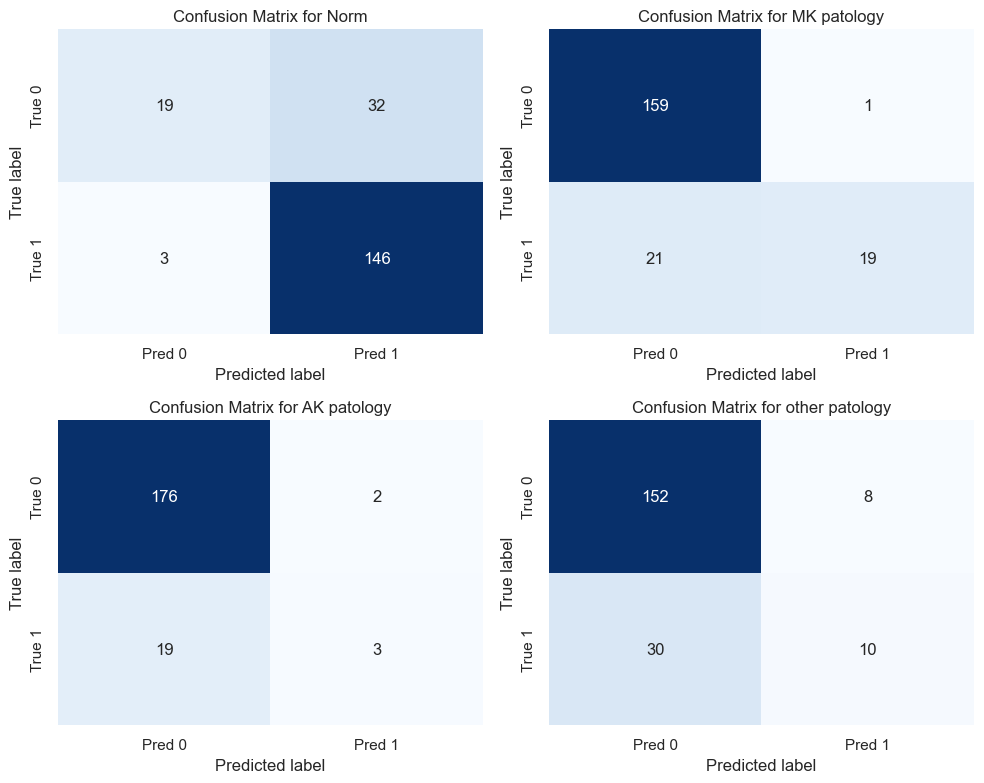

In [142]:
# со всеми данными правильными данными
show_matrix(matrixes['GradientBoosting'], ['Norm', 'MK patology', 'AK patology', 'other patology'])

In [122]:
# с отобранными по локациям данными и правильными данными
results_cdpd_cda

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.769231,0.746154,0.707692,0.761538
f1,0.759088,0.710983,0.755922,0.713968
precision,0.830435,0.772518,0.780758,0.745546
recall,0.735294,0.694118,0.747059,0.711765
specificity,0.931429,0.911429,0.900000,0.897143


In [56]:
# с отобранными по локациям данными
results_cdpd_cda

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.815385,0.792308,0.800000,0.807692
f1,0.806499,0.782180,0.813804,0.783651
precision,0.825899,0.805087,0.814764,0.781171
recall,0.815385,0.792308,0.823077,0.807692
specificity,0.953846,0.946154,0.951282,0.938462


In [64]:
matrixes.keys()

dict_keys(['LogisticRegression', 'RandomForest', 'GradientBoosting', 'SVM'])

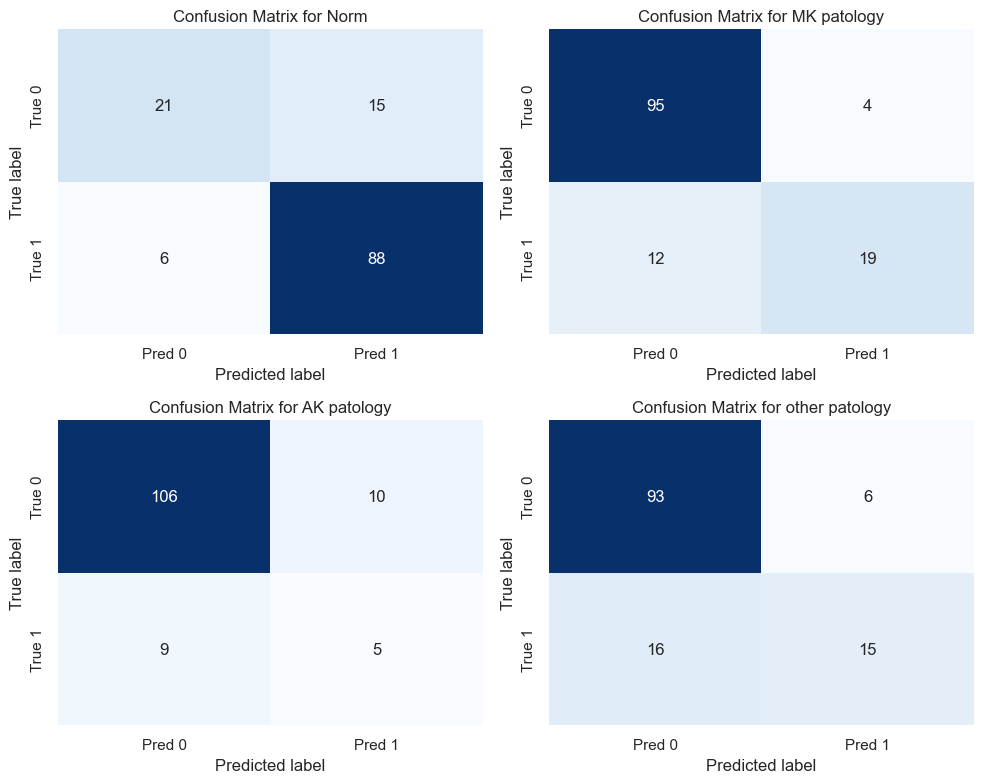

In [123]:
show_matrix(matrixes['GradientBoosting'], ['Norm', 'MK patology', 'AK patology', 'other patology'])

In [ ]:
# со всеми данными
results_cdpd_cda

,LogisticRegression,RandomForest,GradientBoosting,SVM
accuracy,0.795000,0.815000,0.825000,0.820000
f1,0.347637,0.377733,0.397286,0.359418
precision,0.434722,0.453911,0.459538,0.451351
recall,0.330789,0.357466,0.374539,0.343750
specificity,0.940000,0.945000,0.950000,0.940000
